# Mega Yolo -- train the model

## Some toggles for if you want to re-start from weights

In [33]:
# Do you want to re-run from an already generated train/valid/test split?
#  -- this is useful for feature testing and/or re-starting from weights
re_run_from_splits = True

# if restarting, how many previous log files do we want to look at?
nRecent = 7 # for the 1st restart, this will be 1, for the 2nd, 2, etc

# set to true if you are not re-running from the same dataset
regenAnchors = False
 
# use a saved weights file? Set to None if not and training will start anew
#saved_weights_file = 'weights/savedWeights/training_1_model_l0.017813377.h5'
saved_weights_file = None

#fileStorage = 'binaries/' # binaries is where things are -- MAIN   
#extraName = '' # append to training weights name

# for feature collections
#fileStorage = 'binaries_model1/' # binaries is where things are -- MAIN   
#extraName = 'model1' # never use 8, this is our usual model?

#fileStorage = 'binaries_model1_inverted/' # binaries is where things are -- MAIN   
#extraName = 'model1_inverted'

#fileStorage = 'binaries_model1_inverted_palletized/'
#extraName = 'model1_inverted_palletized'

# fileStorage = 'binaries_model2/'
# extraName = 'model2'

#fileStorage = 'binaries_model3/'
#extraName = 'model3'

#fileStorage = 'binaries_model4/'
#extraName = 'model4'

#fileStorage = 'binaries_model5/'
#extraName = 'model5'

#fileStorage = 'binaries_model5_maxTag125/'
#extraName = 'model5_maxTag125'

# fileStorage = 'binaries_model6/'
# extraName = 'model6'

# fileStorage = 'binaries_model8/'
# extraName = 'model8'

fileStorage = 'binaries_model8_tfrecord/'
extraName = 'model8_tfrec'

In [34]:
# toggle for if on google collab or not
import os
thisDir = os.getcwd()
onGoogle = False
if 'content' in thisDir: onGoogle = True

In [35]:

# Mount Google Drive
if onGoogle: # probably on google
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)

In [36]:
if onGoogle: # probably on google
    # find config
    # from pathlib import Path
    # for path in Path('./').rglob('config.py'):
    #     if path.name == 'config.py':
    #         continue
    #print(path)
    if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/scienceDigitization/"):
        print("ERROR: path does not exist")
    os.chdir("/content/gdrive/My Drive/Colab Notebooks/scienceDigitization/")
    import config

    print('On google')
    
    classDirMain = './'
    figCapMain = './'
    
    yoloWeightDir = classDirMain + 'classifications/'

    weightsDir = classDirMain + 'classifications/'
    logsDir = classDirMain + 'classifications/'

    classDirMain = './classifications/'
    classDirMainHOME = fileStorage 
    splitsDir = './classifications/'
    logsDir = classDirMain
    chksDir = classDirMain
    saveFile = classDirMain + 'weights/testList.csv'
else:
    print('on laptop')
    import config
    classDirMain = config.save_binary_dir #+ fileStorage
    #figCapMain = '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/'
    #from sys import path; path.append('/Users/jillnaiman/scienceDigitization/')
    # where are raw images?
    images_pulled_dir = config.images_jpeg_dir #'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/' ## what about Dropbox though????
    yoloWeightDir = config.save_weights_dir
    #weightsDir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/mega_yolo/saved_weights/' # weights/
    logsDir = config.save_weights_dir #'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/mega_yolo/' # weights/
    classDirMainHOME = fileStorage 
    # note -- we are generally not running locally, so this is really tmp storage
    splitsDir = config.tmp_storage_dir #'/Users/jillnaiman/tmpModels/mega_yolo/'
    weightsDir = splitsDir
    logsDir = splitsDir
    chksDir = splitsDir
    saveFile = config.tmp_storage_dir + 'testList.csv'
    # make if not there
    if not os.path.exists(weightsDir+'weights/'):
        os.makedirs(weightsDir+'weights/')


on laptop


In [37]:
# # some parameters for different architectures of YOLO
batch_size = 10
num_epochs = 125 #150 #300

#IMAGE_H, IMAGE_W = 512, 512
image_size = config.IMAGE_H # assume width=height

TRAIN_BATCH_SIZE = batch_size #10
VAL_BATCH_SIZE   = batch_size #10

In [38]:
weightsDir

'/Users/jillnaiman/Downloads/tmp/'

In [39]:
# where annotations and features files
#classDir_main_to = classDirMain + 'yolo_512x512_cap_ann/'
#classDir_main_to_imgs = classDirMain + 'binaries/'#+ 'yolo_512x512/'
classDir_main_to = classDirMain + config.ann_name + str(int(config.IMAGE_H)) + 'x' + str(int(config.IMAGE_W))  + '_ann/'

classDir_main_to_imgs = classDirMain + fileStorage.split('/')[-2] + '/'
classDir_main_to, classDir_main_to_imgs

('/Users/jillnaiman/MegaYolo/yolo_512x512_ann/',
 '/Users/jillnaiman/MegaYolo/binaries_model8_tfrecord/')

In [40]:
#!conda install numba --yes
#logsDir

In [41]:
import os
import glob
import re
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.cElementTree as ET

# make more better?
#from numba import jit
from time import perf_counter
import sys

# for v5
import math
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers

In [42]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
#print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import tensorflow.keras.backend as K
#from tensorflow.keras.layers import Concatenate, concatenate, Dropout, \
#   LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, \
#   BatchNormalization, Flatten, Dense, Lambda
import imgaug as ia
from imgaug import augmenters as iaa

# my imports
import pickle
#from classification_utils import make_get_csv
import pandas as pd
from PIL import Image
import json
#from classification_utils import train_test_valid_split
from scipy import stats
import shutil

# for restart
from tensorflow.python.summary.summary_iterator import summary_iterator
import struct
from datetime import date as DATE

# get parse
from mega_yolo_utils import build_model, train_test_valid_split, \
    process_box, process_layer, box_iou, compute_nms, iou, num_cluster, generator, \
    get_n_features
from general_utils import parse_annotation

Tensorflow version : 2.4.1


## First, data setup

In data pre-processing (`generate_features_only.py`) TF records files are created.

In [45]:
train_list = glob.glob(classDir_main_to_imgs + 'train_*tfrecords')
valid_list = glob.glob(classDir_main_to_imgs + 'valid_*tfrecords')
#test_list = glob.glob(classDir_main_to_imgs + 'test_*tfrecords')

In [48]:
# get raw data
train_raw_data = tf.data.TFRecordDataset(train_list)
valid_raw_data = tf.data.TFRecordDataset(valid_list)

2021-12-03 11:18:29.816391: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
# Create a dictionary describing the features.
image_feature_description = {
    'nbox': tf.io.FixedLenFeature([], tf.float32),
    'nfeatures': tf.io.FixedLenFeature([], tf.float32),
    'boxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
}

If we don't have access to anchors file and train/test/valid files -- read from splits.  Either way, get the labels from a file.

In [53]:
LABELS = np.loadtxt(classDir_main_to_imgs + 'LABELS.csv', 
                    dtype=str, delimiter=',')
CLASS = len(LABELS)

In [55]:
# if we have anchors already
def _parse_just_boxes(example_proto):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # parse the data
    nboxes = image_features['nbox']
    nfeatures = image_features['nfeatures']
    boxes = tf.io.decode_raw(image_features['boxes'],tf.float32)
    boxes = tf.reshape(boxes,[nboxes,5])  
    return boxes

In [86]:
if re_run_from_splits: regenAnchors = False

if regenAnchors:
#if True:
    boxes = train_raw_data.map(lambda example_proto:_parse_just_boxes(example_proto))
    saved_boxes = []
    for ib,b in enumerate(boxes):
        if ib%500 == 0: print('on', ib, 'of ? (probably 5000ish for full)')
        saved_boxes.append(b.numpy())
    # valid
    boxes = valid_raw_data.map(lambda example_proto:_parse_just_boxes(example_proto))
    for ib,b in enumerate(boxes):
        if ib%500 == 0: print('on', ib, 'of ? (probably 5000*0.15ish for valid)')
        saved_boxes.append(b.numpy())

In [85]:
# assume location of saved anchors:
saveFileAnchors = classDirMain + 'weights/anchors.pickle'
# hack for local debugging
if '/Users/jillnaiman' in thisDir:
    saveFileAnchors = splitsDir + 'anchors.pickle'

if regenAnchors:
#if True:
    boxes = []
    for bb in saved_boxes:
        if len(bb) > 0:
            for b in bb:
                boxes.append([b[2]-b[0], b[3]-b[1]])
    boxes = np.array(boxes)
    
    anchors = generator(boxes,k=num_cluster)
    print('NEW ANCHORS:')
    
    # save!
    with open(saveFileAnchors, 'wb') as ff:
        pickle.dump(anchors, ff)
else:
    print('from saved:')
    with open(saveFileAnchors, 'rb') as f:
        anchors = pickle.load(f)    
    
print(anchors)

from saved:
[[203. 118.]
 [ 19. 355.]
 [377. 373.]
 [ 24.   4.]
 [182.   9.]
 [199.  22.]
 [  6.  45.]
 [434.  16.]
 [334. 216.]]


In [83]:
b.shape

(3, 5)

In [50]:
# if we have anchors already
def _parse_image_function(example_proto,anchors,CLASS):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # parse the data
    nboxes = image_features['nbox']
    nfeatures = image_features['nfeatures']
    boxes = tf.io.decode_raw(image_features['boxes'],tf.float32)
    boxes = tf.reshape(boxes,[nboxes,5])
    images_raw = image_features['image_raw']
    image = tf.io.decode_raw(images_raw,tf.float32)
    image = tf.reshape(image,[config.IMAGE_H,config.IMAGE_W,nfeatures])
    # process boxes -- wrap in a tf.py_function
    y1,y2,y3 = tf.py_function(process_box,
                              (boxes[:,:4], boxes[:,4],anchors,CLASS),
                              (tf.float32,tf.float32,tf.float32))   
    return image, y1,y2,y3

In [51]:
train_dataset = train_raw_data.map(lambda example_proto:_parse_image_function(example_proto,
                                                                              anchors,CLASS))


NameError: in user code:

    /var/folders/t5/9xgccmv92hnfvjwd62mk8zqh0000gn/T/ipykernel_49094/719601195.py:1 None  *
        anchors,CLASS))

    NameError: name 'anchors' is not defined


In [ ]:
***HERE**

In [11]:
# Grab labels
annotations = glob.glob(classDir_main_to + '*')
len(annotations)

5515

Parse annotations -- **NOTE: this can take a while!**

In [12]:
#tags

In [13]:
##### what about anchors -- do we want to regenerate? Generally keep this as True...
#####regenAnchors = True
# ... unless we are re-running from a previous split
if re_run_from_splits: regenAnchors = False
#if regenAnchorsAnyway: regenAnchors = True

if regenAnchors:
    bboxes = []
    

# this parsing does some loading on collab that I'm not 100% sure about, but seems necessary
#   to load into memory, so keep it and figure it out later
def load_parse_data_split(X_full):
    Y_full_str = np.array([]) # have to loop and give best guesses for the pages that have multiple images/classes in them
    slabels = np.array([])
    for ii, X in enumerate(X_full):
        if ii%200 == 0: print('on ', ii, ' of ', len(X_full))
        tree = ET.parse(X)
        tags = np.array([])
        for elem in tree.iter(): 
            if 'object' in elem.tag or 'part' in elem.tag:                  
                box = np.zeros((5))
                for attr in list(elem):
                    if 'name' in attr.tag:
                        if attr.text is not None:
                            tags = np.append(tags,attr.text)
                            slabels = np.append(slabels,attr.text)
                        #print(tags, slabels)
                    if regenAnchors:
                        if 'bndbox' in attr.tag and 'bndboxOrig' not in attr.tag:
                            for dim in list(attr):
                                if 'xmin' in dim.tag:
                                    box[0] = int(round(float(dim.text)))
                                if 'ymin' in dim.tag:
                                    box[1] = int(round(float(dim.text)))
                                if 'xmax' in dim.tag:
                                    box[2] = int(round(float(dim.text)))
                                if 'ymax' in dim.tag:
                                    box[3] = int(round(float(dim.text)))
                if regenAnchors and len(box)>0: bboxes.append(np.asarray(box))
        if len(tags) > 0:
            #print(tags)
            modeClass = stats.mode(tags).mode[0] # most frequent class that pops up on this page
            Y_full_str = np.append(Y_full_str, modeClass) # class in string
        else:
            Y_full_str = np.append(Y_full_str, 'none')
    return Y_full_str,slabels

# NEXT: do a quick test run-through of the data generator for train/test splits
X_full = np.array(annotations)

start_time = perf_counter( )
Y_full_str,slabels = load_parse_data_split(X_full)
stop_time = perf_counter( )
print('    Elapsed wall clock time = %g seconds.' % (stop_time - start_time) )
    
# also do regeneration of anchors
if regenAnchors: bboxes = np.array(bboxes)

on  0  of  5515
on  200  of  5515
on  400  of  5515
on  600  of  5515
on  800  of  5515
on  1000  of  5515
on  1200  of  5515
on  1400  of  5515
on  1600  of  5515
on  1800  of  5515
on  2000  of  5515
on  2200  of  5515
on  2400  of  5515
on  2600  of  5515
on  2800  of  5515
on  3000  of  5515
on  3200  of  5515
on  3400  of  5515
on  3600  of  5515
on  3800  of  5515
on  4000  of  5515
on  4200  of  5515
on  4400  of  5515
on  4600  of  5515
on  4800  of  5515
on  5000  of  5515
on  5200  of  5515
on  5400  of  5515
    Elapsed wall clock time = 2506.05 seconds.


Get anchors, if that is what you wanna do:

In [14]:
classDirMain

'./classifications/'

In [15]:
# assume location of saved anchors:
saveFileAnchors = classDirMain + 'weights/anchors.pickle'
# hack for local debugging
if '/Users/jillnaiman' in thisDir:
    saveFileAnchors = splitsDir + 'anchors.pickle'

if regenAnchors:
    boxes = []
    for b in bboxes:
        boxes.append([b[2]-b[0], b[3]-b[1]])
    boxes = np.array(boxes)
    
    anchors = generator(boxes,k=num_cluster)
    print('NEW ANCHORS:')
    
    # save!
    with open(saveFileAnchors, 'wb') as ff:
        pickle.dump(anchors, ff)
else:
    print('from saved:')
    with open(saveFileAnchors, 'rb') as f:
        anchors = pickle.load(f)    
    
print(anchors)

from saved:
[[195.  21.]
 [203.   7.]
 [ 51.   5.]
 [313. 199.]
 [359. 391.]
 [435.  16.]
 [399. 307.]
 [204. 114.]
 [ 15. 355.]]


In [16]:
LABELS = np.unique(slabels).tolist()
CLASS = len(LABELS)
##if use_only_one_class: CLASS = 1
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [17]:
# strings to integers

if not re_run_from_splits:
    Y_full = []
    labels = np.arange(len(LABELS))

    for i in range(len(Y_full_str)):
        try:
            Y_full.append( labels[np.array(LABELS) == Y_full_str[i]][0] +1 ) # 0 means unlabeled data
        except:
            Y_full.append( 0 ) # 0 means unlabeled data

        if len(labels[np.array(LABELS) == Y_full_str[i]]) > 1:
            import sys
            sys.exit()

    Y_full = np.array(Y_full)
else:
    labels = np.arange(0,len(LABELS))

In [18]:
labels, LABELS

(array([0, 1, 2, 3]), ['figure', 'figure caption', 'math formula', 'table'])

Create splits one way or the other.  Using the function makes sure the classes are evenly split as there can be un-even classes (for example, there might be way more figures/figure captions than tables).  Note: each instance is tagged as having one class but this is just the most frequent type on that page -- pages can sometimes have multiple types.

Or, load from previous file.

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


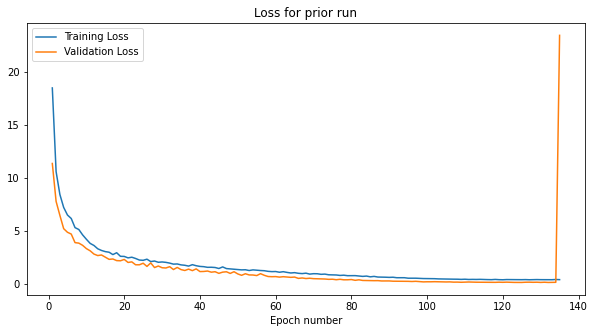

In [19]:
# splits
train_per = 0.75
valid_per = 0.15
test_per = 0.10
if not re_run_from_splits:
    # note: y_* aren't actually used anywhere
    X_train, y_train, X_valid, y_valid, X_test, y_test = train_test_valid_split(X_full, Y_full, 
                                                                  train_size = train_per, valid_size = valid_per, test_size = test_per, 
                                                                  textClassification=True, asInts=False)

    print('We have AT LEAST', len(X_train), 'training,', len(X_valid), 'validation,', len(X_test), 'test instances.')
    
    # write files for splits
    np.savetxt(splitsDir + 'train.csv', X_train, fmt='%s', delimiter=',')
    np.savetxt(splitsDir + 'test.csv', X_test, fmt='%s', delimiter=',')
    np.savetxt(splitsDir + 'valid.csv', X_valid, fmt='%s', delimiter=',')
else: # read from files
    X_train = np.loadtxt(splitsDir + 'train.csv', dtype=str, delimiter=',')
    X_test = np.loadtxt(splitsDir + 'test.csv', dtype=str, delimiter=',')
    X_valid = np.loadtxt(splitsDir + 'valid.csv', dtype=str, delimiter=',')
    if '/Users/jillnaiman' in thisDir: # probably should update if we have copied from google to local
        Xtmp = []
        for i in range(len(X_train)):
            Xtmp.append(classDir_main_to+X_train[i].split('/')[-1])
        X_train = Xtmp
        Xtmp = []
        for i in range(len(X_valid)):
            Xtmp.append(classDir_main_to+X_valid[i].split('/')[-1])
        X_valid = Xtmp
        Xtmp = []
        for i in range(len(X_test)):
            Xtmp.append(classDir_main_to+X_test[i].split('/')[-1])
        X_test = Xtmp
        
    # if rerun, do it!
    logFiles = glob.glob(logsDir+'logs/training_1'+extraName+'/events*')
    logFiles.sort()
    #nRecent = 7
    logFile = logFiles[-nRecent:] # most N recent
    loss = []; val_loss = []; step = []
    for l in logFile:
        for summary in summary_iterator(l):
            #print(summary)
            if summary.step > 0: # only after start
                ent = summary.summary.value[0]
                if ent.tag == 'loss':
                    loss.append(struct.unpack('f', ent.tensor.tensor_content)[0])
                elif ent.tag == 'val_loss':
                    val_loss.append(struct.unpack('f', ent.tensor.tensor_content)[0])
                else:
                    print('not sure:', ent)
                step.append(summary.step)
    step = np.unique(step).tolist()

    # plot
    stop = min([len(step),len(loss)])
    if len(step[:stop]) > 0: # only plot if we have something
        fig,ax = plt.subplots(figsize=(10,5))
        ax.plot(step[:stop],loss[:stop],label='Training Loss')
        stop = min([len(step),len(val_loss)])
        ax.plot(step[:stop],val_loss[:stop], label='Validation Loss')
        ax.set_xlabel('Epoch number')
        ax.set_title('Loss for prior run')
        ax.legend()
        plt.show()
    
    # also, check for new annotations, add to new lists
    X_all = X_train.copy()
    if type(X_all) is not list: X_all = X_all.tolist()
    X_all.extend(X_valid.copy())
    X_all.extend(X_test.copy())
    if len(X_train)+len(X_valid)+len(X_test) < len(annotations): # we have new annotations from last run!
        # pick out new annotations
        X_new = []; Y_new_str = []
        for a,yfs in zip(annotations,Y_full_str):
            if a not in X_all:
                X_new.append(a); Y_new_str.append(yfs)

        Y_new = []
        labels = np.arange(len(LABELS))

        for i in range(len(Y_new_str)):
            try:
                Y_new.append( labels[np.array(LABELS) == Y_new_str[i]][0] +1 ) # 0 means unlabeled data
            except:
                Y_new.append( 0 ) # 0 means unlabeled data

            if len(labels[np.array(LABELS) == Y_new_str[i]]) > 1:
                import sys
                sys.exit()

        Y_new = np.array(Y_new)
        X_new = np.array(X_new)

        # resplit
        # note: y_* aren't actually used anywhere
        X_train_new, y_train_new, X_valid_new, \
        y_valid_new, X_test_new, y_test_new = train_test_valid_split(X_new, Y_new, 
                                                                    train_size = train_per, 
                                                                      valid_size = valid_per, test_size = test_per, 
                                                                    textClassification=True, asInts=False)

        print('We have', len(X_train_new), 'training,', len(X_valid_new), 'validation,', len(X_test_new), 'test NEW instances.')
        # add
        if type(X_train) is not list: X_train = X_train.tolist()
        if type(X_valid) is not list: X_valid = X_valid.tolist()
        if type(X_test) is not list: X_test = X_test.tolist()
        X_train.extend(X_train_new)
        X_valid.extend(X_valid_new)
        X_test.extend(X_test_new)
        print('We have', len(X_train), 'training,', len(X_valid), 'validation,', len(X_test), 'test TOTAL instances.')
        # move old
        shutil.copyfile(splitsDir + 'train.csv', splitsDir + 'train_old.csv')
        shutil.copyfile(splitsDir + 'valid.csv', splitsDir + 'valid_old.csv')
        shutil.copyfile(splitsDir + 'test.csv', splitsDir + 'test_old.csv')
        # write files for "filled in" splits
        np.savetxt(splitsDir + 'train.csv', X_train, fmt='%s', delimiter=',')
        np.savetxt(splitsDir + 'test.csv', X_test, fmt='%s', delimiter=',')
        np.savetxt(splitsDir + 'valid.csv', X_valid, fmt='%s', delimiter=',')


Steps per epoch -- training:

In [20]:
#steps = len(X_train) // batch_size
#print(len(X_train)//batch_size)
# can do larger with augmentation

#aug_fac = 2 # 2 or 3

aug_fac = 1 # 2 or 3


steps_training = (len(X_train)//batch_size)*aug_fac
# factor of 2 from: https://stackoverflow.com/questions/49922252/choosing-number-of-steps-per-epoch

steps_val = (len(X_valid)//batch_size)*aug_fac

print('Steps per epoch = training:', steps_training, ', validation:', steps_val)

Steps per epoch = training: 413 , validation: 82


Save also the names of the test instances to use later:

In [21]:
# save test list in an extra place... this is a bit redundant since its saved another place too
#if not re_run_from_splits:
np.savetxt(saveFile, X_test, delimiter=',',fmt='%s')
print('Hey, saved tests!')

Hey, saved tests!


# 1. Define YOLO model

For v5, see: https://github.com/jahongir7174/YOLOv5-tf

For creating the model -- how many features are we using:

In [22]:
n_features = get_n_features(classDir_main_to_imgs)
n_features

12

In [23]:
tf.keras.backend.clear_session()
version = 'l' # large version
model = build_model(n_features, anchors, version, len(LABELS))

Build YOLOv5:

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                2)]                                                               
                                                                                                  
 tf.nn.space_to_depth (TFOpLamb  (None, 256, 256, 48  0          ['input_1[0][0]']                
 da)                            )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  27648       ['tf.nn.space_to_depth[0][0]']   
                                )                                                             

In [25]:
# plot if you wanna
#tf.keras.utils.plot_model(model_v5, "yolo_v5.png", show_shapes=True, show_layer_names=True, expand_nested=False)

For optimizer:

In [26]:
LRrate = 0.004
#LRrate = 0.002

class CosineLR(tf.optimizers.schedules.LearningRateSchedule):
    def __init__(self,steps):
        super().__init__()
        self.lr = LRrate * batch_size / 64
        self.warmup_init = LRrate/10.
        self.warmup_step = steps
        self.decay_steps = tf.cast((num_epochs - 1) * self.warmup_step, tf.float32)

    def __call__(self, step):
        linear_warmup = tf.cast(step, dtype=tf.float32) / self.warmup_step * (self.lr - self.warmup_init)
        cosine_lr = 0.5 * self.lr * (1 + tf.cos(math.pi * tf.cast(step, tf.float32) / self.decay_steps))
        return tf.where(step < self.warmup_step, self.warmup_init + linear_warmup, cosine_lr)

    def get_config(self):
        pass

In [27]:
optimizer = tf.keras.optimizers.Adam(CosineLR(steps_training), 0.937)

In [28]:
# load weights if you wanna
if saved_weights_file is not None:
    weightsFiles = glob.glob(weightsDir + 'weights/' + '*h5')
    # OR
    if saved_weights_file is not None:
      weightsFiles = [classDirMain+saved_weights_file]
    model.load_weights(weightsFiles[0])

In [29]:
#print(weightsFiles)
optimizer.learning_rate.lr

0.000625

For saving checkpoints:

In [30]:
# for saving model
#save_model_name = chksDir + 'checkpoints/'+'model' + str(DATE.today().year).zfill(4) + str(DATE.today().month).zfill(2) + str(DATE.today().day).zfill(2) +'.h5'
#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_model_name, save_best_only=True)
# today = str(DATE.today().year).zfill(4) + str(DATE.today().month).zfill(2) + str(DATE.today().day).zfill(2)
# if not os.path.exists(chksDir + 'checkpoints/'+today):
#     os.mkdir(chksDir + 'checkpoints/'+today)

In [31]:
#model2 = tf.saved_model.load(save_model_name)

In [32]:
# if restart_from_checkpoints:
#     if saved_model_file is None:
#         files = glob.glob(chksDir + 'checkpoints/*')
#         files.sort()
#         model = tf.saved_model.load(files[-1])
#         fname = files[-1]
#     else:
#         model = tf.saved_model.load(chksDir + 'checkpoints/' +saved_model_file)
#         fname = chksDir + 'checkpoints/' +saved_model_file
#     print('Loading model from', fname)

# For processing data:

In [33]:
classDirMain

'./classifications/'

In [34]:
classDir_main_to_imgs, classDir_main_to

('./classifications/binaries_model8/', './classifications/yolo_512x512_ann/')

In [35]:
#import mega_yolo_utils
#reload(mega_yolo_utils)

In [36]:
from mega_yolo_utils import augmentation_generator, csv_gen

In [37]:
splitsDirIn = None
if onGoogle: splitsDirIn = classDirMain
train_gen_csv = csv_gen('train', splitsDir=splitsDirIn)
valid_gen_csv = csv_gen('valid',splitsDir=splitsDirIn)
test_gen_csv = csv_gen('test',splitsDir=splitsDirIn)

# def csv_gen(split):
#     ftrain = open(splitsDir+'train.csv','r')
#     fvalid = open(splitsDir+'valid.csv','r')
#     ftest = open(splitsDir+'test.csv','r')    
#     while True:
#     #for i in range(100000):
#         if b'train' in bytes(split, encoding='utf8'): # NOTE, must be bytes here!!!
#             line = ftrain.readline()
#             if line == "": # if EOF => loop back to start
#                 ftrain.seek(0)
#                 line = ftrain.readline()
#         elif b'valid' in bytes(split, encoding='utf8'):
#             line = fvalid.readline()
#             if line == "": # if EOF => loop back to start
#                 fvalid.seek(0)
#                 line = fvalid.readline()
#         elif b'test' in bytes(split, encoding='utf8'):
#             line = ftest.readline()
#             if line == "": # if EOF => loop back to start
#                 ftest.seek(0)
#                 line = ftest.readline()
#                 # make sure if we are evaluating with the test set 
#                 #  we don't loop back to the start of the file
#                 break 
#         else:
#             print('NOPE!')
#             sys.exit()
#         yield line
        
# train_gen_csv = csv_gen('train')
# valid_gen_csv = csv_gen('valid')
# test_gen_csv = csv_gen('test')

def dataset_gen(split, batch_size):
    while True:
        true_boxes = []; imgs = []; files = []
        
        while len(files) < batch_size:
            if type(split) == str:
                if b'train' in bytes(split, encoding='utf8'): # NOTE, must be bytes here!!!
                    line = next(train_gen_csv)
                elif b'valid' in bytes(split, encoding='utf8'):
                    line = next(valid_gen_csv)
                elif b'test' in bytes(split, encoding='utf8'):
                    line = next(test_gen_csv)
            else:
                if b'train' in split: # NOTE, must be bytes here!!!
                    line = next(train_gen_csv)
                elif b'valid' in split:
                    line = next(valid_gen_csv)
                elif b'test' in split:
                    line = next(test_gen_csv)
            
            files.append(line.strip())

        # parse and get full names
        try:
            imgs_name, bbox = parse_annotation(files, LABELS, 
                                               feature_dir=classDir_main_to_imgs,
                                               annotation_dir=classDir_main_to)
        except:
            print('error parsing:', imgs_name)
        # do a debug check
        for im in imgs_name:
            if '.npz' not in im:
                print('no np file')
                import sys; sys.exit()
        
        # read in and keep images -- npy files
        for im in imgs_name:
            b = np.load(im)['arr_0']
            
            ########### DEBUGGING ##########
            #b = b[:,:,:3]
            ################################
            
            # convert 0-1
            b = b/255.0
            imgs.append(b)
        
        # finally, format for output
        y_true1, y_true2, y_true3 = [],[],[]
        for b in bbox:
            y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
            y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)
        # if there is no box, do something different
        if len(bbox) == 0:
            # fake a box
            b = np.array([[111.,  59., 403., 364. ,  4.]])
            y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
            y1[:] = 0; y2[:]=0;y3[:]=0
            y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)        
        img = tf.cast(np.array(imgs), tf.float32)        
        yield img, tf.cast(y_true1, tf.float32), tf.cast(y_true2, tf.float32), tf.cast(y_true3, tf.float32)
        

def dataset_gen_for_aug(split, batch_size): # for training/validation datasets
    while True:
        true_boxes = []; imgs = []; files = []
        
        while len(files) < batch_size:
            if type(split) == str:
                if b'train' in bytes(split, encoding='utf8'): # NOTE, must be bytes here!!!
                    line = next(train_gen_csv)
                elif b'valid' in bytes(split, encoding='utf8'):
                    line = next(valid_gen_csv)
                elif b'test' in bytes(split, encoding='utf8'):
                    line = next(test_gen_csv)
            else:
                if b'train' in split: # NOTE, must be bytes here!!!
                    line = next(train_gen_csv)
                elif b'valid' in split:
                    line = next(valid_gen_csv)
                elif b'test' in split:
                    line = next(test_gen_csv)
            
            files.append(line.strip())

        # parse and get full names
        imgs_name, bbox = parse_annotation(files, LABELS, 
                                           feature_dir=classDir_main_to_imgs,
                                            annotation_dir=classDir_main_to)
        # do a debug check
        for im in imgs_name:
            if '.npz' not in im:
                print('no np file')
                import sys; sys.exit()
        
        # read in and keep images -- npy files
        for im in imgs_name:
            b = np.load(im)['arr_0']
            # convert 0-1
            b = b/255.0
            imgs.append(b)
                
        img = tf.cast(np.array(imgs), tf.float32)        
        yield img, tf.cast(bbox, tf.float32)
        

def get_dataset(split, labels, batch_size, use_aug=True):
    if use_aug and ('test' not in split.lower()):
        dataset = tf.data.Dataset.from_generator(dataset_gen_for_aug, args=[split, batch_size],
                                                 output_types = (tf.float32, tf.float32))
    else:
        dataset = tf.data.Dataset.from_generator(dataset_gen, args=[split, batch_size],
                                             output_types = (tf.float32, tf.float32, 
                                                             tf.float32, tf.float32))
                                             
    dataset = dataset.prefetch(10)
    
    # maybe?
    iterator = iter(dataset)

    #return dataset
    return iterator

In [38]:
# grab data!
train_dataset = None
train_dataset= get_dataset('train', LABELS, TRAIN_BATCH_SIZE)

val_dataset = None
val_dataset= get_dataset('valid', LABELS,VAL_BATCH_SIZE,use_aug=False)

In [39]:
#next(valid_gen_csv)
#next(train_dataset)

In [40]:
#val_dataset= get_dataset('valid', LABELS, VAL_BATCH_SIZE,use_aug=True)
#next(val_dataset)

Including Augmentation like a boss!

In [41]:
aug_train_dataset = augmentation_generator(train_dataset, anchors, CLASS)

For calculating the loss:

In [42]:
class ComputeLoss(object):
    def __init__(self):
        super().__init__()

    @staticmethod
    def compute_loss(y_pred, y_true, anchors):
        grid_size = tf.shape(y_pred)[1:3]
        ratio = tf.cast(tf.constant([image_size, image_size]) / grid_size, tf.float32)
        batch_size = tf.cast(tf.shape(y_pred)[0], tf.float32)

        x_y_offset, pred_boxes, pred_conf, pred_prob = process_layer(y_pred, anchors,CLASS)

        object_mask = y_true[..., 4:5]

        def cond(idx, _):
            return tf.less(idx, tf.cast(batch_size, tf.int32))

        def body(idx, mask):
            valid_true_boxes = tf.boolean_mask(y_true[idx, ..., 0:4],
                                               tf.cast(object_mask[idx, ..., 0], 'bool'))
            iou = box_iou(pred_boxes[idx], valid_true_boxes)
            return idx + 1, mask.write(idx, tf.cast(tf.reduce_max(iou, axis=-1) < 0.2, tf.float32))

        ignore_mask = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        
        #print('here1.1')
        #print(cond, body, ignore_mask)

        _, ignore_mask = tf.while_loop(cond=cond, body=body, loop_vars=[0, ignore_mask])
        
        #print('here1.2')
        ignore_mask = ignore_mask.stack()
        ignore_mask = tf.expand_dims(ignore_mask, -1)

        true_xy = y_true[..., 0:2] / ratio[::-1] - x_y_offset
        pred_xy = pred_boxes[..., 0:2] / ratio[::-1] - x_y_offset

        true_tw_th = y_true[..., 2:4] / anchors
        pred_tw_th = pred_boxes[..., 2:4] / anchors
        true_tw_th = tf.where(tf.equal(true_tw_th, 0), tf.ones_like(true_tw_th), true_tw_th)
        pred_tw_th = tf.where(tf.equal(pred_tw_th, 0), tf.ones_like(pred_tw_th), pred_tw_th)
        true_tw_th = tf.math.log(tf.clip_by_value(true_tw_th, 1e-9, 1e+9))
        pred_tw_th = tf.math.log(tf.clip_by_value(pred_tw_th, 1e-9, 1e+9))

        box_loss_scale = y_true[..., 2:3] * y_true[..., 3:4]
        box_loss_scale = 2. - box_loss_scale / tf.cast(image_size ** 2, tf.float32)

        xy_loss = tf.reduce_sum(tf.square(true_xy - pred_xy) * object_mask * box_loss_scale)
        wh_loss = tf.reduce_sum(tf.square(true_tw_th - pred_tw_th) * object_mask * box_loss_scale)

        conf_pos_mask = object_mask
        conf_neg_mask = (1 - object_mask) * ignore_mask
        conf_loss_pos = conf_pos_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=object_mask, logits=pred_conf)
        conf_loss_neg = conf_neg_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=object_mask, logits=pred_conf)
        # try this
        #conf_loss_pos = conf_pos_mask * -tf.reduce_sum(object_mask*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))
        #conf_loss_neg = conf_neg_mask * -tf.reduce_sum(object_mask*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))


        conf_loss = tf.reduce_sum((conf_loss_pos + conf_loss_neg))

        true_conf = y_true[..., 5:]

        class_loss = object_mask * tf.nn.sigmoid_cross_entropy_with_logits(true_conf, pred_prob)
        #class_loss = object_mask * -tf.reduce_sum(true_conf*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))
        #class_loss = object_mask * tf.losses.categorical_crossentropy(true_conf, pred_prob)
        #tf.losses.sparse_softmax_cross_entropy(y, logits)
        class_loss = tf.reduce_sum(class_loss) # sum across all -- 1 number for loss

        if np.isnan(xy_loss):
          print('xy_loss is NaN')
        if np.isnan(wh_loss):
          print('wh_loss is NaN')
        if np.isnan(conf_loss):
          print('conf_loss is NaN')#, conf_loss_pos, conf_loss_neg)
        if np.isnan(class_loss):
          print('class_loss is NaN')

        if np.isnan(xy_loss + wh_loss + conf_loss + class_loss):
          print('--- object mask ---')
          print(object_mask.numpy().shape, pred_conf.numpy().shape, true_conf.numpy().shape)
          print(object_mask.numpy().max(), object_mask.numpy().min())
          print(object_mask)
          print(' ')
          print('--------')
        #else:
        #  print(object_mask.numpy().max(), object_mask.numpy().min())

        return xy_loss + wh_loss + conf_loss + class_loss

    def __call__(self, y_pred, y_true):
        loss = 0.
        anchor_group = [anchors[6:9], anchors[3:6], anchors[0:3]]

        for i in range(len(y_pred)):
            loss += self.compute_loss(y_pred[i], y_true[i], anchor_group[i])
        return loss

In [43]:
loss_object = ComputeLoss()

In [44]:
def compute_loss(y_true, y_pred):
    total_loss = loss_object(y_pred, y_true)
    return tf.reduce_sum(total_loss) / batch_size

In [45]:
def train_step(image, y_true):
    with tf.GradientTape() as tape:
        y_pred = model(image, training=True)
        loss = compute_loss(y_true, y_pred)
    if not np.isnan(loss):
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        #if np.isnan(loss):
        #  print('nan')
        #  print
        optimizer.apply_gradients(zip(gradients, variables))
    else: # this will stop if we have non-convergence 
        print('is NaN -- probably want to lower your learning rate!!!!')
        import sys; sys.exit()
    return loss

In [46]:
# save weights
def save_best_weights(model, name, val_loss_avg):
    # delete existing weights file
    files = glob.glob(os.path.join(weightsDir + 'weights/', name + '*'))
    for file in files:
        os.remove(file)
    # create new weights file
    name = name + '_model_' +version + str(val_loss_avg) + '.h5'
    path_name = os.path.join(weightsDir +'weights/', name)
    model.save_weights(path_name)
    
    
# log (tensorboard)
def log_loss(loss, val_loss, step):
    tf.summary.scalar('loss', loss, step)
    tf.summary.scalar('val_loss', val_loss, step)

In [47]:
classDir_main_to

'./classifications/yolo_512x512_ann/'

In [48]:
# training
def train(epochs, model, train_dataset, val_dataset, steps_per_epoch_train, 
          steps_per_epoch_val, optimizer, train_name = 'train'):
    '''
    Train YOLO model for n epochs.
    Eval loss on training and validation dataset.
    Log training loss and validation loss for tensorboard.
    Save best weights during training (according to validation loss).

    Parameters
    ----------
    - epochs : integer, number of epochs to train the model.
    - model : YOLO model.
    - train_dataset : YOLO ground truth and image generator from training dataset.
    - val_dataset : YOLO ground truth and image generator from validation dataset.
    - steps_per_epoch_train : integer, number of batch to complete one epoch for train_dataset.
    - steps_per_epoch_val : integer, number of batch to complete one epoch for val_dataset.
    - train_name : string, training name used to log loss and save weights.
    
    Notes :
    - train_dataset and val_dataset generate YOLO ground truth tensors : detector_mask,
      matching_true_boxes, class_one_hot, true_boxes_grid. Shape of these tensors (batch size, tensor shape).
    - steps per epoch = number of images in dataset // batch size of dataset
    
    Returns
    -------
    - loss history : [train_loss_history, val_loss_history] : list of average loss for each epoch.
    '''
    num_epochs1 = epochs
    steps_per_epoch_train = steps_per_epoch_train
    steps_per_epoch_val = steps_per_epoch_val
    train_loss_history = []
    val_loss_history = []
    best_val_loss = 1e6
    
    # optimizer
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer = tf.summary.create_file_writer(os.path.join(logsDir+'logs/', train_name), 
                                                   flush_millis=20000)
    summary_writer.set_as_default()
    
    # training
    for epoch in range(num_epochs1):
        epoch_loss = []
        epoch_val_loss = []
        epoch_val_sub_loss = []
        print('Epoch {} :'.format(epoch))
        # train
        for batch_idx in range(steps_per_epoch_train):        
            image, y_true_1, y_true_2, y_true_3 = next(train_dataset)
            y_true = (y_true_1, y_true_2, y_true_3)
            loss = train_step(image, y_true)
            # check for nans
            optOrig = optimizer.learning_rate.lr
            while np.isnan(loss):
              print('loss nan')
              optimizer.learning_rate.lr *= 0.5
              loss = train_step(image, y_true)
            epoch_loss.append(loss)
            print('-', end='')
        print(' | ', end='')
        # val
        for batch_idx in range(steps_per_epoch_val): 
            image, y_true_1, y_true_2, y_true_3 = next(val_dataset)
            y_true = (y_true_1, y_true_2, y_true_3)
            loss = train_step(image, y_true)
            epoch_val_loss.append(loss)
            print('-', end='')

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = np.mean(np.array(epoch_val_loss))
        train_loss_history.append(loss_avg)
        val_loss_history.append(val_loss_avg)
        
        # log
        log_loss(loss_avg, val_loss_avg, epoch)
        
        # save
        if val_loss_avg < best_val_loss:
            save_best_weights(model, train_name, val_loss_avg)
            best_val_loss = val_loss_avg
            #tf.saved_model.save(model, chksDir + 'checkpoints/'+today)        
        print(' loss = {:.4f}, val_loss = {:.4f}'.format(loss_avg, val_loss_avg))
        
    return [train_loss_history, val_loss_history]

In [49]:
results = train(num_epochs, model, aug_train_dataset, val_dataset, 
               steps_training, steps_val, optimizer,'training_1'+extraName)

# debug
#results = train(num_epochs, model, aug_train_dataset, val_dataset, 
#               1, 1, optimizer,'training_1'+extraName)

Epoch 0 :
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- loss = 1248.1118, val_loss = 70.4698
Epoch 1 :
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -----------------------------

UnknownError: ignored

Plot diagnostics:

In [ ]:
fig, ax = plt.subplots(figsize=(30,14))
ax.plot(results[0], label='Training Loss')
ax.plot(results[1], label='Validation Loss')
plt.legend()

In [ ]:
# imgs_name, bbox = parse_annotation([X_train[0]], LABELS, 
#                                    classDir_main_to_imgs=classDir_main_to_imgs,
#                                        classDir_main_to_ann=classDir_main_to)


In [ ]:
# from importlib import reload
# reload(parse_annotation)

In [ ]:
#import general_utils

In [ ]:
#reload(general_utils)

In [ ]:
#from general_utils import parse_annotation